# Day 3 - Polygons

In [1]:
import pandas as pd
import json
import urllib.request
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# get details of all Nandos from Food Standards Agency
surl='http://ratings.food.gov.uk/search-name/en-gb/NANDOS/1/1000/json'
fsa = json.loads(urllib.request.urlopen(surl).read())
lstFSA=[]
for f in fsa["FHRSEstablishment"]["EstablishmentCollection"]["EstablishmentDetail"]:
    if f["BusinessName"].upper()[:5]=='NANDO':
        lstFSA.append([f["BusinessName"],f["PostCode"],f["LocalAuthorityName"],
                       f["Geocode"]["Latitude"],f["Geocode"]["Longitude"],f["RatingDate"],f["AddressLine1"]])
dfFSA=pd.DataFrame(lstFSA,columns=['name','pc','la','lat','lon','date','thoroughfare']).fillna('')
dfFSA.name.value_counts()[:5]

Nando's                    248
Nandos                      97
Nando's Chickenland Ltd     20
Nando's Chickenland         14
Nandos Chickenland Ltd       8
Name: name, dtype: int64

In [4]:
print("How many?",len(dfFSA))

How many? 439


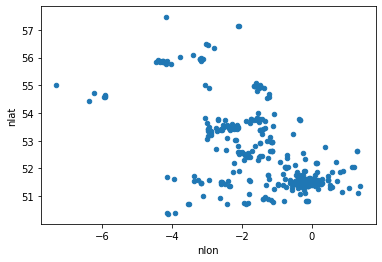

In [5]:
# create numeric lat/lon and plot very rough map - squashed due to flat projection
dfFSA['nlon']=pd.to_numeric(dfFSA.lon, errors='coerce')
dfFSA['nlat']=pd.to_numeric(dfFSA.lat, errors='coerce')
dfFSA.plot(kind='scatter',x='nlon',y='nlat')
plt.show()

 <h2>ONSPD</h2>
 Download ONS Postcode Directory from  <a>https://geoportal.statistics.gov.uk/datasets/ons-postcode-directory-february-2020</a> 


In [6]:
onspd=r'ONSPD_FEB_2020_UK.csv'
dfONSPD=pd.read_csv(onspd, low_memory=False)
dfONSPD.sample(2)

,pcd,pcd2,pcds,dointr,doterm,oscty,ced,oslaua,osward,parish,...,ru11ind,oac11,lat,long,lep1,lep2,pfa,imd,calncv,stp
507853,CO9 2EF,CO9 2EF,CO9 2EF,199412,199606.0,E10000012,E58000434,E07000067,E05012962,E04012931,...,C1,5A1,51.94512,0.642244,E37000030,NaN,E23000028,15538,E56000009,E54000026
1689561,OL165QL,OL16 5QL,OL16 5QL,198704,198812.0,E99999999,E99999999,E08000005,E05000746,E43000159,...,A1,4B2,53.61166,-2.148088,E37000015,NaN,E23000005,1259,E57000001,E54000007


In [7]:
# Create postcode to local authority lookup
dfPCLA=dfONSPD[['pcds','oslaua']]
dfPCLA.to_csv('PostcodeToLocalAuthority.csv')

In [8]:
dfPCLA.sample(2)

,pcds,oslaua
1656055,NW1 4AA,E09000007
1651394,NR5 9WB,E07000144


In [9]:
# Add the la code to the FSA data joining on postcode
dfCoded=dfFSA.merge(dfPCLA,how='left',left_on='pc',right_on='pcds')
dfCoded.sample(2)

,name,pc,la,lat,lon,date,thoroughfare,nlon,nlat,pcds,oslaua
128,Nando's,CT1 2BG,Canterbury City,51.2806435,1.077113,04 October 2019,46 St Peter's Street,1.077113,51.280643,CT1 2BG,E07000106
364,Nandos,B2 4BF,Birmingham,{'@xsi:nil': 'true'},{'@xsi:nil': 'true'},08 October 2019,Unit 34,NaN,NaN,B2 4BF,E08000025


In [10]:
# Calculate the required stat (number of Nandos) for each la area
dfStat=dfCoded.oslaua.value_counts().reset_index(name='stat')
dfStat.columns=['lacode','stat']
dfStat[:5]

,lacode,stat
0,E09000033,11
1,E08000025,10
2,E08000003,8
3,E08000035,8
4,E09000022,8


 <h2>ONS Local Authority boundaries</h2>Download LA shapefile from <a>https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2019-boundaries-uk-bfc</a>

In [11]:
# read in shapefile
shpla=r'Local_Authority_Districts_December_2019_Boundaries_UK_BFC.shp'
dfLA=gpd.read_file(shpla)
dfLA.sample(2)

,objectid,lad19cd,lad19nm,lad19nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
251,252,E08000004,Oldham,None,396603,406784,-2.05274,53.557678,1.423449e+08,71165.731538,"POLYGON ((398550.799 413290.596, 398573.497 41..."
184,185,E07000168,Scarborough,None,495798,495548,-0.52778,54.346500,8.161884e+08,241939.745650,"MULTIPOLYGON (((478293.700 518865.500, 478304...."


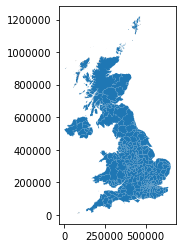

In [12]:
# check LA shapefile
dfLA.plot()
plt.show()

In [13]:
# add stat to shapefile
dfMap=dfLA.merge(dfStat,how='left',left_on='lad19cd',right_on='lacode').fillna(0)
dfMap.sample(2)

,objectid,lad19cd,lad19nm,lad19nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,lacode,stat
65,66,E07000026,Allerdale,0,317520,532997,-3.28090,54.685242,1.258292e+09,326945.356863,"MULTIPOLYGON (((322753.803 562802.595, 322767....",0,0.0
28,29,E06000031,Peterborough,0,517372,300777,-0.26874,52.592140,3.433782e+08,112678.124728,"POLYGON ((531399.296 310254.500, 531826.596 31...",E06000031,1.0


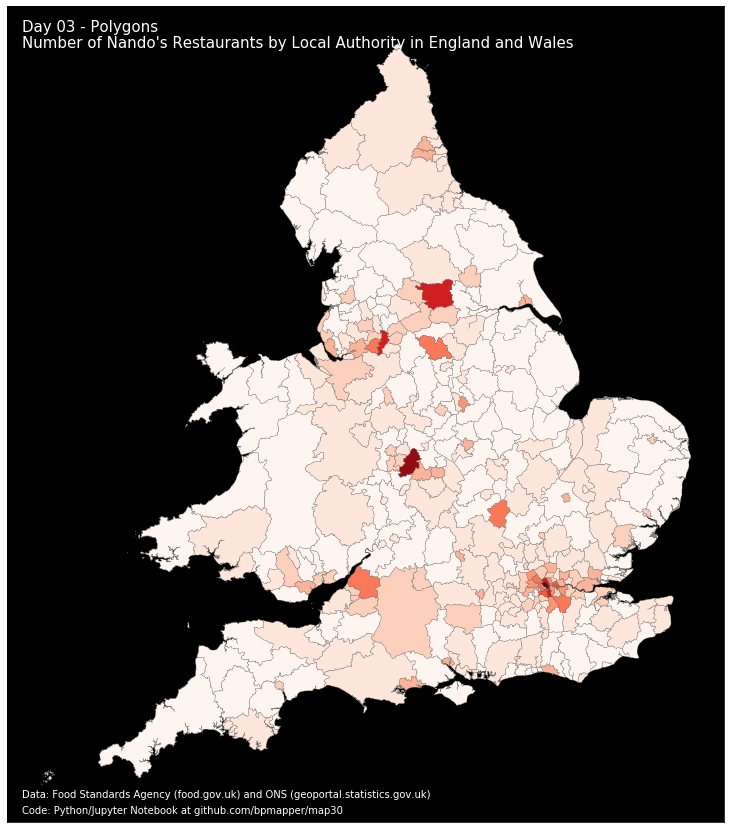

In [28]:
# map it - 
fig,ax=plt.subplots(figsize=(15,15))
dfMap[dfMap.lad19cd.str[:1].isin(['E','W'])].plot(
           ax=ax, 
           linewidth=0.25, 
           edgecolor='grey',
           column='stat',
           cmap="Reds")
ax.text(.02,.97,'Day 03 - Polygons',transform=ax.transAxes, fontsize=15).set_color('white')
ax.text(.02,.95,'Number of Nando\'s Restaurants by Local Authority in England and Wales',transform=ax.transAxes, fontsize=15).set_color('white')       
ax.text(.02,.03,'Data: Food Standards Agency (food.gov.uk) and ONS (geoportal.statistics.gov.uk)',transform=ax.transAxes, fontsize=10).set_color('white')       
ax.text(.02,.01,'Code: Python/Jupyter Notebook at github.com/bpmapper/map30',transform=ax.transAxes, fontsize=10).set_color('white')       
plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
ax.set_facecolor('black')
fig.savefig('Day03_Polygons.png')

plt.show()

In [18]:
# Top 5
dfMap.sort_values('stat',ascending=False)[:5]

,objectid,lad19cd,lad19nm,lad19nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,lacode,stat
316,317,E09000033,Westminster,0,528268,180870,-0.15295,51.512199,2.147716e+07,27430.623439,"POLYGON ((526735.197 183706.204, 526772.704 18...",E09000033,11.0
271,272,E08000025,Birmingham,0,408150,287352,-1.88141,52.484039,2.677911e+08,106260.720207,"POLYGON ((411959.601 301124.003, 412032.603 30...",E08000025,10.0
290,291,E09000007,Camden,0,527492,184284,-0.16289,51.543060,2.178930e+07,26150.818382,"POLYGON ((527180.702 187584.204, 527198.701 18...",E09000007,8.0
281,282,E08000035,Leeds,0,432528,436384,-1.50736,53.822731,5.517065e+08,161521.909191,"POLYGON ((443381.702 450063.500, 443370.398 45...",E08000035,8.0
250,251,E08000003,Manchester,0,384591,397063,-2.23359,53.470089,1.156482e+08,86851.090158,"POLYGON ((384062.800 404997.000, 384174.001 40...",E08000003,8.0
